In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu');

In [3]:
def createFolder(directory):
  try:
    if not os.path.exists(directory):
      os.makedirs(directory)
  except OSerror:
    print("Error")
createFolder("./data")

In [4]:
ds_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
train_ds = datasets.MNIST('./data', train=True, download=True, transform=ds_transform)
val_ds = datasets.MNIST('./data', train=False, download=True, transform=ds_transform)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 335333967.11it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26425762.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 171640021.76it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7178044.00it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([128, 1, 28, 28]) torch.Size([128])


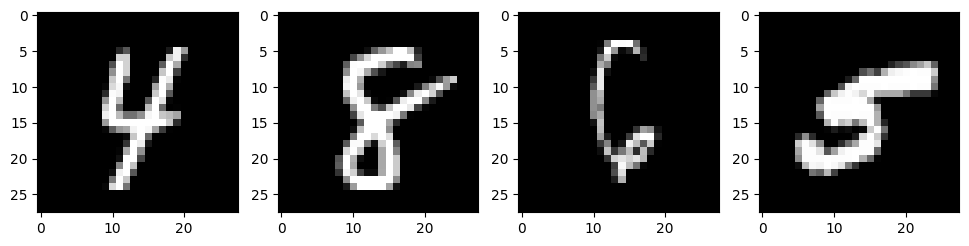

In [6]:
for x, y in train_dl:
  print(x.shape, y.shape)
  break;

num = 4
img = x[:num]

plt.figure(figsize=(15, 15))
for i in range(num):
  plt.subplot(1, num+1, i+1)
  plt.imshow(to_pil_image(0.1307*img[i]+0.3801), cmap='gray')

In [7]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1200)
        self.bn1 = nn.BatchNorm1d(1200)
        self.fc2 = nn.Linear(1200,1200)
        self.bn2 = nn.BatchNorm1d(1200)
        self.fc3 = nn.Linear(1200, 10)
    
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.dropout(x,p=0.8)
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x,p=0.8)
        x = self.fc3(x)
        return x

In [8]:
x = torch.randn(16, 1, 28, 28).to(device)
teacher = Teacher().to(device)
output = teacher(x)
print(output.shape)

torch.Size([16, 10])


In [9]:
def init_weights(model):
  classname = model.__class__.__name__
  if classname.find('Linear') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
    nn.init.constant_(model.bias.data, 0)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

teacher.apply(init_weights)

Teacher(
  (fc1): Linear(in_features=784, out_features=1200, bias=True)
  (bn1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1200, out_features=1200, bias=True)
  (bn2): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1200, out_features=10, bias=True)
)

In [10]:
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(teacher.parameters())

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [11]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

def metric_batch(output, target):
  pred = output.argmax(1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

def loss_batch(loss_func, output, target, opt=None):
  loss_b = loss_func(output, target)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step()
  
  return loss_b.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b
    
    if sanity_check is True:
      print('sanity_check is True!!')
      break

  loss = running_loss / len_data
  metric = running_metric / len_data
  return loss, metric

def train_val(model, params):
  num_epochs=params['num_epochs']
  loss_func=params['loss_func']
  opt=params['optimizer']
  train_dl=params['train_dl']
  val_dl=params['val_dl']
  sanity_check=params['sanity_check']
  lr_scheduler=params['lr_scheduler']
  path2weights=params['path2weights']

  loss_history = {'train': [], 'val': []}
  metric_history = {'train': [], 'val': []}

  best_loss = float('inf')
  best_model_wts = copy.deepcopy(model.state_dict())
  start_time = time.time()

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

    model.train()
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print('Copied best model weights!')

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading best model weights!')
      model.load_state_dict(best_model_wts)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history

In [12]:
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [13]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/29, current lr=0.001
Copied best model weights!
train loss: 0.003577, val loss: 0.002198, accuracy: 91.19, time: 0.3542 min
----------
Epoch 1/29, current lr=0.001
Copied best model weights!
train loss: 0.002198, val loss: 0.001795, accuracy: 92.82, time: 0.6611 min
----------
Epoch 2/29, current lr=0.001
Copied best model weights!
train loss: 0.001844, val loss: 0.001648, accuracy: 93.64, time: 0.9797 min
----------
Epoch 3/29, current lr=0.001
Copied best model weights!
train loss: 0.001693, val loss: 0.001508, accuracy: 94.48, time: 1.3076 min
----------
Epoch 4/29, current lr=0.001
Copied best model weights!
train loss: 0.001526, val loss: 0.001452, accuracy: 94.45, time: 1.6242 min
----------
Epoch 5/29, current lr=0.001
Copied best model weights!
train loss: 0.001437, val loss: 0.001424, accuracy: 94.44, time: 1.9481 min
----------
Epoch 6/29, current lr=0.001
Copied best model weights!
train loss: 0.001368, val loss: 0.001293, accuracy: 94.87, time: 2.2664 min
----------

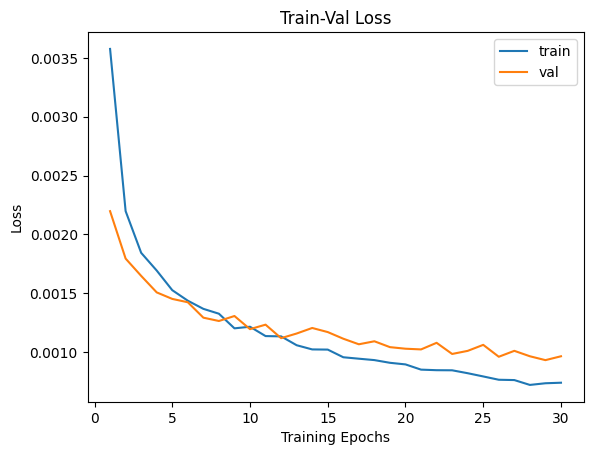

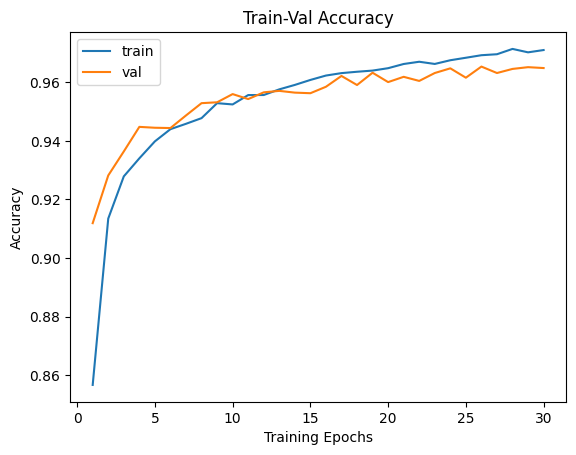

In [14]:
num_epochs = params_train['num_epochs']

plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

In [15]:
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [16]:
student = Student().to(device)

def initialize_weights(model):
    classname = model.__class__.__name__

    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

student.apply(initialize_weights)

Student(
  (fc1): Linear(in_features=784, out_features=800, bias=True)
  (bn1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=800, out_features=800, bias=True)
  (bn2): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=800, out_features=10, bias=True)
)

In [17]:
teacher = Teacher().to(device)

teacher.load_state_dict(torch.load('./models/teacher_weights.pt'))

student = Student().to(device)

opt = optim.Adam(student.parameters())

In [26]:
def distillation(y, labels, teacher_scores, T, alpha):
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T * T * 2.0 + alpha) + F.cross_entropy(y, labels) * (1.-alpha)

loss_func = nn.CrossEntropyLoss()

def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
  loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
  metric_b = metric_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step()

  return loss_b.item(), metric_b

In [27]:
num_epochs = 100

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = student(xb)
        teacher_output = teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(student, loss_func, val_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/99, current lr= 0.001


<ipython-input-26-3faf22ff83fa>:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T * T * 2.0 + alpha) + F.cross_entropy(y, labels) * (1.-alpha)
<ipython-input-26-3faf22ff83fa>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T * T * 2.0 + alpha) + F.cross_entropy(y, labels) * (1.-alpha)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train loss: 0.014481, val loss: 0.000842, accuracy: 97.11, time: 0.3336 min
----------
Epoch 1/99, current lr= 0.001
train loss: 0.011965, val loss: 0.000694, accuracy: 97.66, time: 0.6674 min
----------
Epoch 2/99, current lr= 0.001
train loss: 0.011706, val loss: 0.000705, accuracy: 97.76, time: 1.0038 min
----------
Epoch 3/99, current lr= 0.001
train loss: 0.011600, val loss: 0.000614, accuracy: 97.79, time: 1.3115 min
----------
Epoch 4/99, current lr= 0.001
train loss: 0.011585, val loss: 0.000607, accuracy: 97.83, time: 1.6302 min
----------
Epoch 5/99, current lr= 0.001
train loss: 0.011483, val loss: 0.000541, accuracy: 97.95, time: 1.9348 min
----------
Epoch 6/99, current lr= 0.001
train loss: 0.011475, val loss: 0.000626, accuracy: 97.92, time: 2.2542 min
----------
Epoch 7/99, current lr= 0.001
train loss: 0.011429, val loss: 0.000548, accuracy: 97.98, time: 2.5631 min
----------
Epoch 8/99, current lr= 0.001
train loss: 0.011354, val loss: 0.000602, accuracy: 97.99, time:

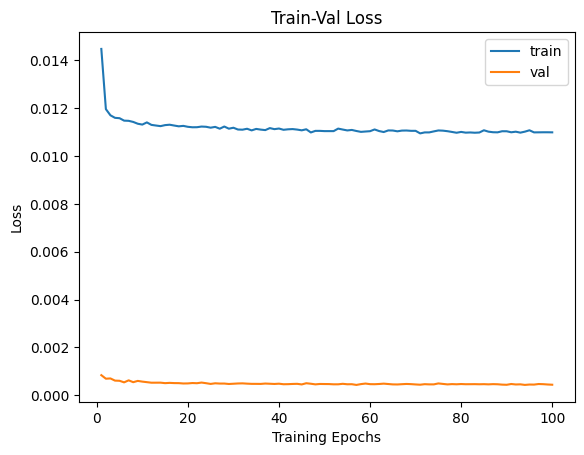

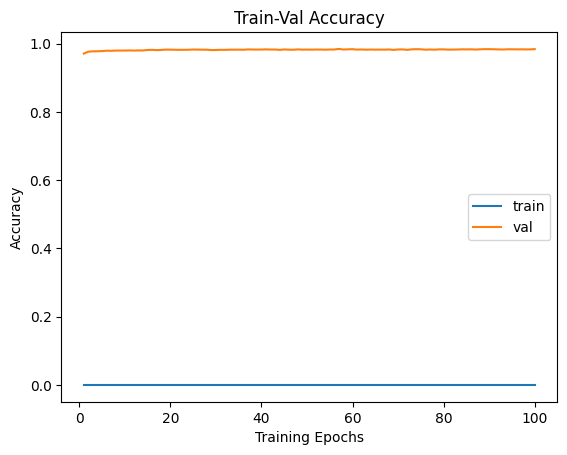

In [29]:
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_history['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_history['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_history['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_history['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()